# AAI614: Data Science & its Applications

*Notebook 4.1: Graph Analytics with cuGraph and TIGER*

<a href="https://colab.research.google.com/github/harmanani/AAI614/blob/main/Week%204/Notebook4.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




The study of network robustness is critical to the understanding of complex interconnected systems. For example, consider an example of a power grid network that is susceptible to both natural failures and targeted attacks. A natural failure occurs when a single power substation fails due to erosion of parts or natural disasters. However, when one substation fails, additional load is routed to alternative substations, potentially causing a series of cascading failures. Not all failures originate from natural causes, some come from targeted attacks, such as enemy states hacking into the grid to sabotage key equipment to maximally damage the operations of the electrical grid. A natural counterpart to network robustness is vulnerability, defined as measure of a network’s susceptibility to the dissemination of entities across the network, such as how quickly a virus spreads across a computer network.

In this lab, we show how to use [cuGraph](https://github.com/rapidsai/cugraph) and [TIGER](https://github.com/safreita1/TIGER) to conduct state-of-the-art GPU accelerated graph vulnerability and robustness analysis. Specifically, we will look at how to:

- *Quantify network vulnerability and robustness* (**Part 1**),
- *Simulate network attacks and cascading failures on networks* (**Part 2**)
- *Regulate the dissemination of computer virues on a network* (**Part 3**)

Lab Source: **NVIDIA**

## Setup
Lets begin by installing the following 2 libraries:

1.   Graph vulnerability and robustness analysis library: [TIGER](https://github.com/safreita1/TIGER)
2.   GPU acceleration library: [CuPy](https://github.com/cupy/cupy)


In [11]:
pip install graph-tiger

In [12]:
import os
print("Current working directory:", os.getcwd())
print("Contents of current directory:")
for item in os.listdir('.'):
    print(f"  {item}")

Current working directory: /content
Contents of current directory:
  .config
  rapidsai-csp-utils
  sample_data


In [13]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git

fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.


In [14]:
import os
file_path = 'rapidsai-csp-utils/colab/update_modules.py'
if os.path.exists(file_path):
    print("File exists!")
else:
    print("File not found. Let's check the repository structure:")
    if os.path.exists('rapidsai-csp-utils'):
        print("Repository exists. Contents:")
        for root, dirs, files in os.walk('rapidsai-csp-utils'):
            for file in files:
                if file.endswith('.py'):
                    print(f"  {os.path.join(root, file)}")
    else:
        print("Repository not found.")

File not found. Let's check the repository structure:
Repository exists. Contents:
  rapidsai-csp-utils/colab/install_rapids.py
  rapidsai-csp-utils/colab/env-check.py
  rapidsai-csp-utils/colab/pip-install.py


In [15]:
import subprocess
import sys

# Install the missing RAPIDSAI packages with CUDA 12 support
missing_packages = [
    "cugraph-cu12",
    "cuspatial-cu12",
    "cuproj-cu12",
    "cuxfilter-cu12"
]

for package in missing_packages:
    print(f"Installing {package}...")
    try:
        subprocess.check_call([
            sys.executable, "-m", "pip", "install",
            package, "--no-cache-dir"
        ])
        print(f"✅ {package} installed successfully")
    except subprocess.CalledProcessError as e:
        print(f"❌ Failed to install {package}: {e}")
    print("-" * 50)

Installing cugraph-cu12...
✅ cugraph-cu12 installed successfully
--------------------------------------------------
Installing cuspatial-cu12...
✅ cuspatial-cu12 installed successfully
--------------------------------------------------
Installing cuproj-cu12...
✅ cuproj-cu12 installed successfully
--------------------------------------------------
Installing cuxfilter-cu12...
✅ cuxfilter-cu12 installed successfully
--------------------------------------------------


In [16]:
import subprocess
import sys

# Check for RAPIDSAI packages
rapidsai_packages = ['cudf', 'cuml', 'cugraph', 'cuspatial', 'cuproj', 'cuxfilter']

print("Checking RAPIDSAI package availability:")
for package in rapidsai_packages:
    try:
        __import__(package)
        print(f"✅ {package} - INSTALLED")
    except ImportError:
        print(f"❌ {package} - NOT INSTALLED")

# Also check pip list for any rapids packages
result = subprocess.run([sys.executable, "-m", "pip", "list"],
                       capture_output=True, text=True)
rapids_lines = [line for line in result.stdout.split('\n') if 'cu' in line.lower()]
print(f"\nInstalled packages with 'cu' in name:")
for line in rapids_lines:
    if line.strip():
        print(f"  {line}")

Checking RAPIDSAI package availability:
✅ cudf - INSTALLED
✅ cuml - INSTALLED
✅ cugraph - INSTALLED
✅ cuspatial - INSTALLED
✅ cuproj - INSTALLED
✅ cuxfilter - INSTALLED

Installed packages with 'cu' in name:
  cuda-python                           12.6.2.post1
  cudf-cu12                             25.6.0
  cudf-polars-cu12                      25.2.2
  cufflinks                             0.17.3
  cugraph-cu12                          25.6.0
  cuml-cu12                             25.2.1
  cuproj-cu12                           25.4.0
  cupy-cuda12x                          13.3.0
  curl_cffi                             0.11.4
  cuspatial-cu12                        25.4.0
  cuvs-cu12                             25.2.1
  cuxfilter-cu12                        25.6.0
  dask-cuda                             25.6.0
  dask-cudf-cu12                        25.6.0
  distributed-ucxx-cu12                 0.44.0
  docutils                              0.21.2
  jax-cuda12-pjrt                 

That's it! Now we can run a variety of GPU acclerated graph mining algorithms.



## Part 1: Quantifing network vulnerability and robustness

While CPU calculations work well for sparse graphs, GPU acceleration significantly speeds-up analysis for dense graphs. To see this, lets run the code below that measures the robustness of a Barabási Albert (BA) graph at varying levels of density (i.e., number of edges per node).

In [20]:
!pip install stopit

  Preparing metadata (setup.py) ... done
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11938 sha256=db88b44a63b134c6ab23bd405cea918c2d152b3ff1910704875349fe5fd8f8b6
  Stored in directory: /root/.cache/pip/wheels/da/77/2d/adbc56bc4db95ad80c6d4e71cd69e2d9d122174904342e3f7f
Successfully built stopit


In [21]:
import time
from tqdm import tqdm

from graph_tiger.measures import run_measure
from graph_tiger.graphs import graph_loader

# controls graph density by varying the number of non-zeroes per row (i.e., number of edges per node in graph)
nnz_per_row = list(range(50, 501, 50))

cpu_times = []
gpu_times = []
for nnz in tqdm(nnz_per_row):
  graph = graph_loader(graph_type='BA', n=1000, m=nnz, seed=1)

  start_cpu = time.time()
  robustness_index = run_measure(graph, measure='average_vertex_betweenness', k=int(0.05 * len(graph)))
  end_cpu = time.time()

  start_gpu = time.time()
  robustness_index = run_measure(graph, measure='average_vertex_betweenness', k=12, use_gpu=True)  # ****** Replace with cuGraph version: https://docs.rapids.ai/api/cugraph/stable/api.html#module-cugraph.centrality.betweenness_centrality ******
  end_gpu = time.time()


  cpu_times.append(round(end_cpu - start_cpu, 2))
  gpu_times.append(round(end_gpu - start_gpu, 2))




100%|██████████| 10/10 [00:31<00:00,  3.16s/it]


Now lets plot the results (lower is better).

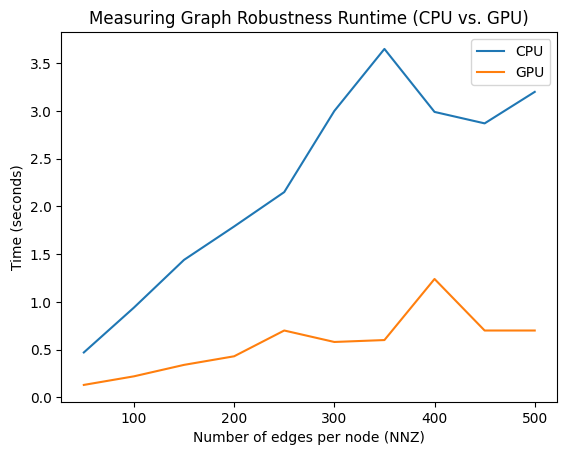

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(nnz_per_row, cpu_times, label='CPU')
plt.plot(nnz_per_row, gpu_times, label='GPU')
plt.xlabel('Number of edges per node (NNZ)')
plt.ylabel('Time (seconds)')
plt.title('Measuring Graph Robustness Runtime (CPU vs. GPU)')
plt.legend()
plt.show()

## Part 2. Simulating Cascading Failures in U.S. Electrical Grid
Cascading failures often arise as a result of natural failures or targeted attacks in a network. There are 3 main processes governing the network simulation:

- the **capacity** of each node (<img src="https://render.githubusercontent.com/render/math?math=c_v">) in the network, e.g., power substation capacity.

- the **load** of each node (<img src="https://render.githubusercontent.com/render/math?math=l_v">) in the network, e.g., power substation load level

- network **redundancy** (*r*) representing the amount of reserve capacity present in the network i.e., auxiliary support systems.

When a node is attacked it becomes "overloaded", causing it to fail and requiring the load be distributed to its neighbors. When defending a node, we increase it’s capacity to protect against attacks. With just these 3 parameters, we can setup a cascading failure simulation. Below, we show how to load a graph representing the U.S. electrical grid and setup the simulation parameters.

In [23]:
from graph_tiger.graphs import graph_loader

graph = graph_loader('electrical')

params = {
   'runs': 1,  # number of times to run the simulation
   'steps': 100,  # number of time steps to run each simulation
   'seed': 1,  # for repoducibility

   'l': 0.8,  # network load [0, 1]
   'r': 0.2,  # network redundancey [0, 1]
   'c': int(0.1 * len(graph)),  # load capacity approximation

   'robust_measure': 'largest_connected_component',  # measure of network health
}

### Setting up a Targeted Attack
To run the attack we just have to modify a few simulation parameters. We set the attack to remove 30 nodes in the graph (e.g., power grid substations) with highest degree centrality "id_node". As you can imagine, there are many different strategies that can be used to attack the grid, however, by selecting degree centrality we can find "central" nodes in the network with many power lines (edges) connected to the substations (nodes).

In [31]:
params.update({
   'k_a': 30,  # number of nodes to attack
   'attack': 'id_node',  # attack strategy
})

In [29]:
# Create a simple replacement for ForceAtlas2
import sys
import types

# Create a mock ForceAtlas2 class
class MockForceAtlas2:
    def __init__(self, *args, **kwargs):
        pass

    def forceatlas2_networkx_layout(self, graph, *args, **kwargs):
        # Use networkx's spring layout as fallback
        import networkx as nx
        return nx.spring_layout(graph)

# Create a mock fa2 module
fa2_module = types.ModuleType('fa2')
fa2_module.ForceAtlas2 = MockForceAtlas2
sys.modules['fa2'] = fa2_module

print("Created mock fa2 module - now try your import:")

Created mock fa2 module - now try your import:


In [34]:
import networkx as nx
import scipy.sparse as sp
import numpy as np

# Add the missing function back to networkx
def to_scipy_sparse_matrix(G, nodelist=None, dtype=None, order=None, format='csr'):
    """Compatibility function for older networkx code"""
    try:
        # Try the new function first (NetworkX >= 2.8)
        return nx.to_scipy_sparse_array(G, nodelist=nodelist, dtype=dtype, format=format)
    except AttributeError:
        # Fallback for older versions
        from networkx.convert_matrix import to_scipy_sparse_matrix as old_func
        return old_func(G, nodelist=nodelist, dtype=dtype, order=order, format=format)

# Monkey patch it back into networkx
nx.to_scipy_sparse_matrix = to_scipy_sparse_matrix

print("✅ Patched networkx.to_scipy_sparse_matrix")

✅ Patched networkx.to_scipy_sparse_matrix


Now lets run the simulation and plot the results!

In [35]:
from graph_tiger.cascading import Cascading

cascading = Cascading(graph, **params)
results = cascading.run_simulation()

cascading.plot_results(results)

Running simulation 1 times


<Figure size 640x480 with 0 Axes>

### 1. Collapsing a network

Now try modifying the code to find the minimal attack necessary to collapse the electrical grid. To do this, plot the "health" of the network as measured by the robustness measure (i.e., "largest_connected_component") at the end of each simulation, against the attack strength ("k_a").

**Hint:** electrical networks are fragile to targeted attacks, try removing just a few nodes.

In [ ]:
sim_results =[]

params['attack'] = 'id_node'
attack_strengths = list(range(0, 6, 1))

for k_a in tqdm(attack_strengths):
  params['k_a'] = k_a

  cascading = Cascading(graph, **params)
  results = cascading.run_simulation()

  lcc_at_end = results[-1]
  sim_results.append(lcc_at_end)

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(attack_strengths, sim_results)
plt.xlabel('Attack strength')
plt.ylabel('Largest connected component')
plt.title('Effect of Attack Strength in Cascading Failures')

  0%|          | 0/6 [00:00<?, ?it/s]

Running simulation 1 times


 17%|█▋        | 1/6 [00:19<01:39, 19.96s/it]

Running simulation 1 times


 33%|███▎      | 2/6 [00:38<01:16, 19.17s/it]

# Part 3. Simulating Computer Virus Spread Across Router Network

The flu-like susceptible-infected-susceptible (SIS) is a popular model that allows us to simulate the spread of viruses across networks (graphs). Each node in the SIS model can be in one of two states, infected *I* or susceptible *S*, and at each time step *t*, an infected node has a probability *β* of infecting each of it's uninfected neighbors. After this, each infected node has a probability *δ* of healing and becoming susceptible again.

It’s been shown there's a direct correlation between the graph's topology as measured through the spectral radius (largest eigenvalue) of the graph, and the virus remaining endemic. The exact relationship between a virus's strength (*s*), birth rate (*β*), death rate (*δ*) and spectral radius (*λ1*) is s=λ1⋅b/d, where a larger *s* means a stronger virus. With just these 3 parameters, we can setup a computer virus simulation.

Below, we (1) load the Autonomous systems AS-733 network, which is a graph of routers comprising the internet; and (2) setup the simulation parameters.  

In [ ]:
from graph_tiger.graphs import graph_loader

graph = graph_loader('as_733')

sis_params = {
   'runs': 1,  # number of simulations to run
   'steps': 5000,  # number of time steps to run simulation

   'model': 'SIS',
   'b': 0.00208,  # virus birth rate
   'd': 0.01,  # virus death rate
   'c': 0.3,  # fraction of the network that starts infected
}

Now lets run the simulation and plot the results! In the figure below, we see that without intervention the virus remains endemic on the router network.

In [ ]:
from graph_tiger.diffusion import Diffusion

diffusion = Diffusion(graph, **sis_params)
results = diffusion.run_simulation()

diffusion.plot_results(results)

While we do not have control over the virus strength (*s*), we can maniuplate the underlying toplogy of the router network to make it harder for the virus to spread. The question is, how do we optimally modify the network to reduce the spread of the virus? While a naive solution may be to disconnect the whole network, this isn't very practical since everyone would loose internet access! Instead, we need a strategy that carefully vaccinates a few nodes (routers) against the virus.

### 2. Optimally Vaccinating a Network

Now lets compare the efficacy of 4 vaccination strategies when vaccinating only 3 nodes in the network:

1. [netshield](https://graph-tiger.readthedocs.io/en/latest/defenses.html#graph_tiger.defenses.get_node_ns) ('ns_node')
2. [id_node](https://graph-tiger.readthedocs.io/en/latest/defenses.html#graph_tiger.defenses.get_node_id) ('id_node')
2. [rd_node](https://graph-tiger.readthedocs.io/en/latest/defenses.html#graph_tiger.defenses.get_node_rd) ('rd_node')
3. [ib_node](https://graph-tiger.readthedocs.io/en/latest/defenses.html#graph_tiger.defenses.get_node_ib) ('ib_node')

To implement a defense strategy you just have to modify a few simulation parameters.

In [ ]:
sis_params.update({
    'diffusion': 'min',  # we want to minimize the ability of the virus to propagate,
    'method': 'ns_node',  # use the Netshield technique
    'k': 15  # vaccinate 5 nodes according the selected strategy
})

Does each strategy manage to contain the virus (i.e., less than 1\% infected population)? Which strategy has the lowest infected population at the end of the simulation? Setup and run each simulation and compare the results to the unvaccinated network.

In [ ]:
methods = ['ns_node', 'id_node', 'rd_node', 'pr_node']

for method in methods:
  sis_params['method'] = method

  diffusion = Diffusion(graph, **sis_params)
  results = diffusion.run_simulation()

  print('Percent of network that remains infected at end of simulation using {} vaccination technique is {}%'.format(method, round((results[-1] / len(graph)) * 100, 2)))
  diffusion.plot_results(results)